## Spacenet

https://medium.com/the-downlinq/establishing-a-machine-learning-workflow-530628cfe67

https://medium.com/the-downlinq/object-detection-on-spacenet-5e691961d257

https://medium.com/the-downlinq/the-spacenet-metric-612183cc2ddb

https://medium.com/the-downlinq/a-baseline-model-for-the-spacenet-4-off-nadir-building-detection-challenge-6b7983312b4b

https://medium.com/the-downlinq


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *


In [4]:
import PIL.Image as pil_image

In [5]:
import fastai
print(fastai.__version__)

1.0.36.dev0


In [6]:
torch.cuda.set_device(0)

In [7]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
print(f'DATE: {DATE}') 

DATE: 20181209


In [8]:
#bs of 8
#DATE='20181204'

In [9]:
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}') 

UID: 13c242d8


In [10]:
#UID='81940436'

In [11]:
ARCH = models.resnet34
ARCH_NAME = 'rn34'
MODEL_NAME = 'unet'

In [12]:
SUB_NUM='1'

In [13]:
path = Path('../../data/SpaceNet_Off-Nadir_Dataset')
path.ls()

[PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Test'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Train'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/test_data'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/masks'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Sample'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/band-triplets.txt'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Sample.tar.gz'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/test_rgb'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/train_rgb'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_test'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/rgb_train')]

In [14]:
ssd_path = Path('../../ssd_data/SpaceNet_Off-Nadir_Dataset')
ssd_path.ls()

[PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/predicted_masks'),
 PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/predicted_masks_900'),
 PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train'),
 PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/masks'),
 PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_masks'),
 PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_test')]

In [15]:
path_original_lbl = path/'masks'
path_original_img = path/'train_rgb'
fnames_original = get_image_files(path_original_img)
lbl_original_names = get_image_files(path_original_lbl)

In [16]:
path_hd_img = path/'resized_train'
path_hd_lbl = path/'resized_masks'
path_hd_test = path/'resized_test'

In [17]:
input_hd_test = path/'test_rgb'

In [18]:
input_test = ssd_path/'test_rgb'

In [25]:
path_img = ssd_path/'resized_train'
path_lbl = ssd_path/'resized_masks'
path_test = ssd_path/'resized_test'
pred_masks = ssd_path/'predicted_masks'

In [26]:
pred_masks_orig_size = ssd_path/'predicted_masks_900'

In [27]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
#in_test_fnames = get_image_files(input_test)
pred_mask_fnames = get_image_files(pred_masks)
fnames[:3], lbl_names[:3] 

([PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir8_catid_10300100023BC100_743051_3741339.png'),
  PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir50_catid_10300100039E6200_743951_3724689.png'),
  PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir19_catid_1030010003C92000_739901_3727839.png')],
 [PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_masks/mask_739901_3739539.png'),
  PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_masks/mask_744851_3734139.png'),
  PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_masks/mask_739901_3735939.png')])

In [71]:
len(fnames), len(lbl_names), len(in_test_fnames)

(28728, 1064, 927)

In [72]:
#only 1064 masks and images - but multiple nadirs

In [73]:
image_ids =[]
image_names=[]
channel_types=[]
nadir_angles=[]
mask_names=[]
nadir_types=[]
for n in fnames:
    parts = str(n).split('_')
    im_id = '_'.join(parts[-2:])
    image_ids.append(im_id)
    indici = [i for i, s in enumerate(parts) if 'nadir' in s]
    indici=indici[0]
    
    nadir_angle = parts[indici].split('nadir')[1]
    nadir_angles.append(nadir_angle)
    if int(nadir_angle) < 26:
        angle_set = 'nadir'
    elif int(nadir_angle) > 25 and int(nadir_angle) < 40:
        angle_set = 'offnadir'
    elif int(nadir_angle) > 40:
        angle_set = 'faroffnadir'
    nadir_types.append(angle_set)
    
    fname_part = str(n).split('/')[-1]
    image_names.append(fname_part)
    
    channel_type = str(fname_part).split('Atlanta')[0][:-1]
    channel_types.append(channel_type)
    
    mask_name = 'mask_'+im_id
    mask_names.append(mask_name)

In [74]:
len(list(set(image_ids)))

1064

In [75]:
train_df = pd.DataFrame(
    {'image_name': image_names,
     'channel_type': channel_types,
     'nadir_angle': nadir_angles,
     'nadir_type': nadir_types,
     'mask_name': mask_names
    })

In [76]:
train_df.head()


,image_name,channel_type,nadir_angle,nadir_type,mask_name
0,Pan-Sharpen_Atlanta_nadir8_catid_10300100023BC...,Pan-Sharpen,8,nadir,mask_743051_3741339.png
1,Pan-Sharpen_Atlanta_nadir50_catid_10300100039E...,Pan-Sharpen,50,faroffnadir,mask_743951_3724689.png
2,Pan-Sharpen_Atlanta_nadir19_catid_1030010003C9...,Pan-Sharpen,19,nadir,mask_739901_3727839.png
3,Pan-Sharpen_Atlanta_nadir13_catid_1030010002B7...,Pan-Sharpen,13,nadir,mask_741701_3721089.png
4,Pan-Sharpen_Atlanta_nadir49_catid_103001000349...,Pan-Sharpen,49,faroffnadir,mask_743951_3726039.png


In [77]:
train_df['channel_type'].unique()

array(['Pan-Sharpen'], dtype=object)

In [78]:
train_df['nadir_angle'].unique()

array(['8', '50', '19', '13', '49', '29', '32', '53', '25', '27', '10', '42', '34', '30', '14', '44', '52', '16', '46',
       '47', '7', '23', '39', '21', '36'], dtype=object)

In [79]:
#### resample example

In [120]:
def show_resized(image_index):
    img_f = train_df['image_name'][image_index]
    mask_n = train_df['mask_name'][image_index]
    img = open_image(path_img/f'{img_f}')
    print(f'img_f: {img_f}, mask_n: {mask_n}')
    mask = open_mask(path_lbl/f'{mask_n}', div=True)
    print(img.size)
    fig,ax = plt.subplots(1,1, figsize=(14,14))
    img.show(ax=ax)
    mask.show(ax=ax, alpha=0.9)

In [121]:
#### original

In [122]:
def show_original(image_index):
    img_f = train_df['image_name'][image_index]
    mask_n = train_df['mask_name'][image_index]
    img_f=img_f.split('.png')[0]
    img_f=img_f+'.tif'
    mask_n=mask_n.split('.png')[0]
    mask_n=mask_n+'.tif'
    img = open_image(path_original_img/f'{img_f}')
    mask = open_mask(path_original_lbl/f'{mask_n}', div=True)
    
    src_size = np.array(mask.shape[1:])
    print(src_size)
    #print(mask.data)

    fig,ax = plt.subplots(1,1, figsize=(14,14))
    img.show(ax=ax)
    mask.show(ax=ax, alpha=1)

img_f: Pan-Sharpen_Atlanta_nadir53_catid_1030010003193D00_744401_3723339.png, mask_n: mask_744401_3723339.png
torch.Size([450, 450])


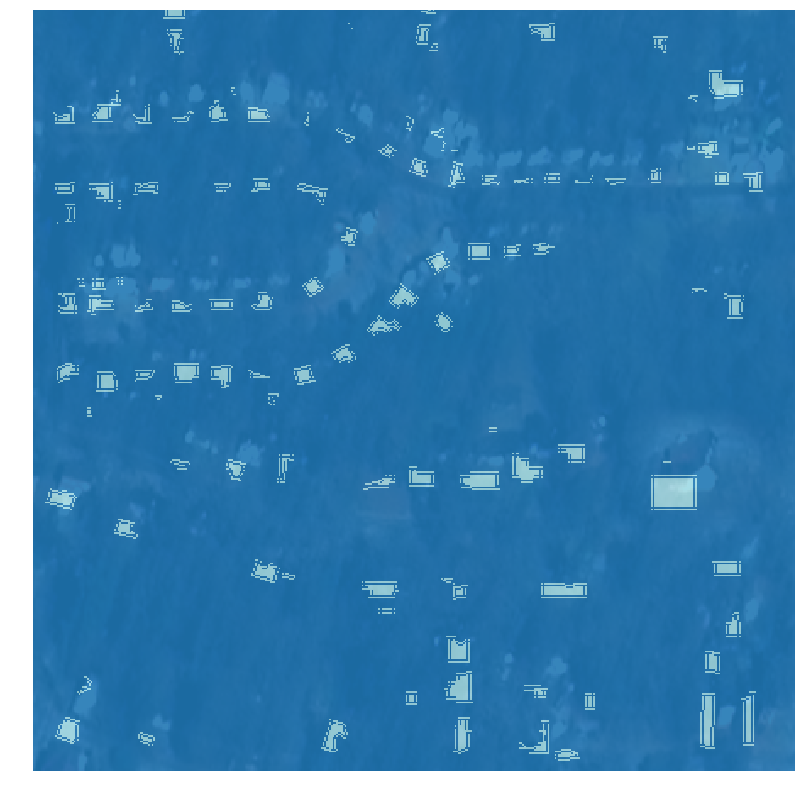

In [123]:
show_resized(10)

[900 900]


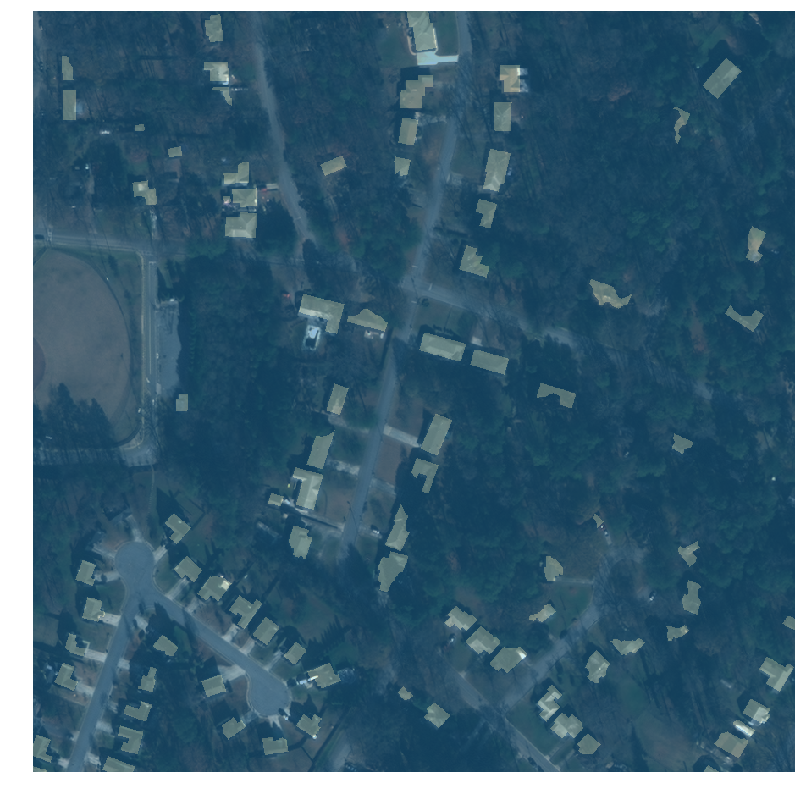

In [31]:
show_original(10)

In [32]:
mask_n = train_df['mask_name'][0]
mask = open_mask(path_lbl/f'{mask_n}', div=True)
src_size = np.array(mask.shape[1:])

In [33]:
mask.shape[1:], src_size

(torch.Size([450, 450]), array([450, 450]))

In [ ]:
mask = open_mask(get_y_fn(img_f))

#### image sizes

In [68]:
def get_sizes(fnames, n=100):
    #get av size of first n images
    widths = []
    heights = []
    if n==0:
        for im in fnames:
            w,h=pil_image.open(im).size
            widths.append(w)
            heights.append(h)
    else:
        for im in fnames[:n]:
            w,h=Image.open(im).size
            widths.append(w)
            heights.append(h)
    av_w = sum(widths)/len(widths)
    av_h = sum(heights)/len(heights)
    print(f'avg width: {av_w}, avg height: {av_h}, max w: {max(widths)}, min w: {min(widths)}, max h: {max(heights)}, min h: {min(heights)}')

In [69]:
#get_sizes(fnames, n=0)


In [70]:
#get_sizes(lbl_names, n=0)

#### resize images

In [91]:
def resize_test(resize_path, fnames, size=(450,450)):
    print(f'>>resize_images: {len(fnames)}, resize_path: {resize_path}, out size: {size}')
    for im in fnames:
        if str(im).endswith('mask_744401_3723339.tif'):
            img=pil_image.open(f'{im}')
            img2 = img.resize(size, pil_image.BILINEAR)
            img2.save(f'resize_BILINEAR_{im.stem}.png')
            img2.close()
            #PIL.Image.NEAREST, PIL.Image.BOX, PIL.Image.BILINEAR, PIL.Image.HAMMING, PIL.Image.BICUBIC or PIL.Image.LANCZOS
            img2 = img.resize(size, pil_image.NEAREST)
            img2.save(f'resize_NEAREST_{im.stem}.png')
            img2.close()
            img2 = img.resize(size, pil_image.BOX)
            img2.save(f'resize_BOX_{im.stem}.png')
            img2.close()
            img2 = img.resize(size, pil_image.HAMMING)
            img2.save(f'resize_HAMMING_{im.stem}.png')
            img2.close()
            img2 = img.resize(size, pil_image.BICUBIC)
            img2.save(f'resize_BICUBIC_{im.stem}.png')
            img2.close()
            img2 = img.resize(size, pil_image.LANCZOS)
            img2.save(f'resize_LANCZOS_{im.stem}.png')
            img2.close()
            img2=img.copy()
            img2.thumbnail(size, resample=pil_image.ANTIALIAS)
            img2.save(f'thumbnail_ANTIALIAS_{im.stem}.png')
            img2.close()
            #print(f'img.size post thumbnail: {img.size}')
            #print(f'saving to: {resize_path}/{im.stem}.png')

In [92]:
def resize_images(resize_path, fnames, size=(450,450)):
    print(f'>>resize_images: {len(fnames)}, resize_path: {resize_path}, out size: {size}')
    for im in fnames:
        assert os.path.isfile(f'{im}') 
        img=pil_image.open(f'{im}')
        img2 = img.resize(size, pil_image.BILINEAR)
        #img.thumbnail(size, pil_image.ANTIALIAS)
        #print(f'img.size post thumbnail: {img.size}')
        #print(f'saving to: {resize_path}/{im.stem}.png')
        img2.save(f'{resize_path}/{im.stem}.png')
        img.close()
        img2.close()


In [93]:
#resize masks
#resize_images(path_lbl, lbl_original_names)
resize_test(path_lbl, lbl_original_names)

>>resize_images: 1064, resize_path: ../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_masks, out size: (450, 450)


#### expand images

In [28]:
def expand_images(out_path, fnames, size=(900,900)):
    for im in fnames:
        img=pil_image.open(im)
        image_bilin = img.resize(size, pil_image.BILINEAR)
        image_bilin.save(f'{out_path}/{im.stem}.png')
        img.close()
        image_bilin.close()

In [29]:
expand_images(pred_masks_orig_size, pred_mask_fnames)